SyntaxError: invalid syntax (357088759.py, line 1)

In [19]:
import os
import pickle
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics

import sqlalchemy
#import snowflake.connector
from sqlalchemy import create_engine
from snowflake.sqlalchemy import *

import xgboost as xgb
from datetime import datetime, timedelta
import time  
import pytz    

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, HuberRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import metrics
from sklearn.metrics import r2_score 



ModuleNotFoundError: No module named 'snowflake.sqlalchemy'; 'snowflake' is not a package

## **Connecting the Data Source Directly**

In the event that you dont want to use SageMaker to process the data, due to financial constraints, you can use this method to work with the data set
 

In [ ]:
data = pd.read_csv("Data/health_data.csv")

In [ ]:
# Assuming you have a DataFrame called "data" with the appropriate columns
# Convert "ADMISSION_DATE" and "DISCHARGE_DATE" to datetime format
data['ADMISSION_DATE'] = pd.to_datetime(data['ADMISSION_DATE'])
data['DISCHARGE_DATE'] = pd.to_datetime(data['DISCHARGE_DATE'])

# Create a new DataFrame "base" with the COALESCE transformations
base = data.copy()  # Create a copy of the original DataFrame

base['HOSPITAL_CODE'] = base['HOSPITAL_CODE'].fillna(0)
base['HOSPITAL_TYPE_CODE'] = base['HOSPITAL_TYPE_CODE'].fillna('None')
base['CITY_CODE_HOSPITAL'] = base['CITY_CODE_HOSPITAL'].fillna(0)
base['HOSPITAL_REGION_CODE'] = base['HOSPITAL_REGION_CODE'].fillna('None')
base['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL'] = base['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL'].fillna(0)
base['DEPARTMENT'] = base['DEPARTMENT'].fillna('None')
base['WARD_TYPE'] = base['WARD_TYPE'].fillna('None')
base['WARD_FACILITY_CODE'] = base['WARD_FACILITY_CODE'].fillna('None')
base['BED_GRADE'] = base['BED_GRADE'].fillna(0)
base['CITY_CODE_PATIENT'] = base['CITY_CODE_PATIENT'].fillna(0)
base['TYPE_OF_ADMISSION'] = base['TYPE_OF_ADMISSION'].fillna('None')
base['SEVERITY_OF_ILLNESS'] = base['SEVERITY_OF_ILLNESS'].fillna('Minor')
base['VISITORS_WITH_PATIENT'] = base['VISITORS_WITH_PATIENT'].fillna(0)
base['AGE'] = base['AGE'].fillna('None')
base['ADMISSION_DEPOSIT'] = base['ADMISSION_DEPOSIT'].fillna(0)

# Create a new DataFrame "base_with_features" with additional transformations
base_with_features = base.copy()

base_with_features['ADMISSION_YEAR'] = base_with_features['ADMISSION_DATE'].dt.year
base_with_features['ADMISSION_MONTH'] = base_with_features['ADMISSION_DATE'].dt.month
base_with_features['ADMISSION_DAY'] = base_with_features['ADMISSION_DATE'].dt.day
base_with_features['ADMISSION_MONTH_NAME'] = base_with_features['ADMISSION_DATE'].dt.month_name()
base_with_features['ADMISSION_DAY_NAME'] = base_with_features['ADMISSION_DATE'].dt.day_name()
base_with_features['ADMISSION_ILLNESS_COMB'] = base_with_features['TYPE_OF_ADMISSION'] + '-' + base_with_features['SEVERITY_OF_ILLNESS']
base_with_features['ILLNESS_BEDGRADE_COMB'] = base_with_features['SEVERITY_OF_ILLNESS'] + '-' + base_with_features['BED_GRADE'].astype(str)
base_with_features['DEPARTMENT_ILLNESS_COMB'] = base_with_features['DEPARTMENT'] + '-' + base_with_features['SEVERITY_OF_ILLNESS']


base_with_features['LENGTH_OF_STAY'] = (base_with_features['DISCHARGE_DATE'] - base_with_features['ADMISSION_DATE']).dt.days

# Additional categorization using CASE statement
def categorize_stay_duration(row):
    duration = row['LENGTH_OF_STAY']
    if duration <= 7:
        return 'Short Stay'
    elif duration <= 14:
        return 'Medium Stay'
    else:
        return 'Long Stay'

base_with_features['STAY_DURATION'] = base_with_features.apply(categorize_stay_duration, axis=1)

# Now, you have the equivalent Python code for the SQL query with datetime conversion and corrected column name
result = base_with_features.copy()

# You can print or work with the "result" DataFrame as needed
print(result)


        CASE_ID  HOSPITAL_CODE HOSPITAL_TYPE_CODE  CITY_CODE_HOSPITAL  \
0             1              8                  c                   3   
1             3             10                  e                   1   
2             4             26                  b                   2   
3             5             26                  b                   2   
4             6             23                  a                   6   
...         ...            ...                ...                 ...   
236699   255877             23                  a                   6   
236700   255879              3                  c                   3   
236701   255880              3                  c                   3   
236702   255882             19                  a                   7   
236703   255883             14                  a                   1   

       HOSPITAL_REGION_CODE  AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL    DEPARTMENT  \
0                         Z                

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236704 entries, 0 to 236703
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   CASE_ID                            236704 non-null  int64         
 1   HOSPITAL_CODE                      236704 non-null  int64         
 2   HOSPITAL_TYPE_CODE                 236704 non-null  object        
 3   CITY_CODE_HOSPITAL                 236704 non-null  int64         
 4   HOSPITAL_REGION_CODE               236704 non-null  object        
 5   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int64         
 6   DEPARTMENT                         236704 non-null  object        
 7   WARD_TYPE                          236704 non-null  object        
 8   WARD_FACILITY_CODE                 236704 non-null  object        
 9   BED_GRADE                          236704 non-null  float64       
 10  PATIENTID           

## **Connecting the data source, directly from Snowflake**

In [ ]:
snowflake_creds = {
    'USER_NAME': '',
    'PASSWORD': ''
}

In [ ]:
#creating the connection
engine = create_engine(URL(
    account = '',#account region
    user = snowflake_creds['USER_NAME'],
    password = snowflake_creds['PASSWORD'],
    role = 'ACCOUNTADMIN',
    warehouse = 'COMPUTE_WH',
    database ='HEALTHDB',
    schema='HEALTHSCHEMA'
))

In [ ]:
query = """

WITH BASE AS (
    SELECT
        CASE_ID,
        COALESCE(HOSPITAL_CODE, 0) AS HOSPITAL_CODE,
        COALESCE(HOSPITAL_TYPE_CODE, 'None') AS HOSPITAL_TYPE_CODE,
        COALESCE(CITY_CODE_HOSPITAL, 0) AS CITY_CODE_HOSPITAL,
        COALESCE(HOSPITAL_REGION_CODE, 'None') AS HOSPITAL_REGION_CODE,
        COALESCE(AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL, 0) AS AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,
        COALESCE(DEPARTMENT, 'None') AS DEPARTMENT,
        COALESCE(WARD_TYPE, 'None') AS WARD_TYPE,
        COALESCE(WARD_FACILITY_CODE, 'None') AS WARD_FACILITY_CODE,
        COALESCE(BED_GRADE, 0) AS BED_GRADE,
        PATIENTID,
        COALESCE(CITY_CODE_PATIENT, 0) AS CITY_CODE_PATIENT,
        COALESCE(TYPE_OF_ADMISSION, 'None') AS TYPE_OF_ADMISSION,
        COALESCE(SEVERITY_OF_ILLNESS, 'Minor') AS SEVERITY_OF_ILLNESS,
        COALESCE(VISITORS_WITH_PATIENT, 0) AS VISITORS_WITH_PATIENT,
        COALESCE(AGE, 'None') AS AGE,
        COALESCE(ADMISSION_DEPOSIT, 0) AS ADMISSION_DEPOSIT,
        ADMISSION_DATE,
        DISCHARGE_DATE
    FROM HEALTHDB.HEALTHSCHEMA.HEALTH_DATA
    WHERE ADMISSION_DATE IS NOT NULL AND DISCHARGE_DATE IS NOT NULL -- Ensure dates are valid
),
    
BASE_WITH_FEATURES AS (
    SELECT *,
        -- Extract year, month, and day as separate columns
        YEAR(ADMISSION_DATE) AS ADMISSION_YEAR,
        MONTH(ADMISSION_DATE) AS ADMISSION_MONTH,
        DAY(ADMISSION_DATE) AS ADMISSION_DAY,
        MONTHNAME(ADMISSION_DATE) AS ADMISSION_MONTH_NAME,
        DAYNAME(ADMISSION_DATE) AS ADMISSION_DAY_NAME,
        CONCAT(TYPE_OF_ADMISSION, '-', SEVERITY_OF_ILLNESS) AS ADMISSION_ILLNESS_COMB,
        CONCAT(SEVERITY_OF_ILLNESS, '-', CAST(BED_GRADE AS VARCHAR)) AS ILLNESS_BEDGRADE_COMB,
        CONCAT(DEPARTMENT, '-', SEVERITY_OF_ILLNESS) AS DEPARTMENT_ILLNESS_COMB,
        CASE -- Additional categorization using CASE statement
            WHEN DATEDIFF(day, ADMISSION_DATE, DISCHARGE_DATE) <= 7 THEN 'Short Stay'
            WHEN DATEDIFF(day, ADMISSION_DATE, DISCHARGE_DATE) <= 14 THEN 'Medium Stay'
            ELSE 'Long Stay'
        END AS STAY_DURATION,
        DATEDIFF(day, ADMISSION_DATE, DISCHARGE_DATE) AS LENGHTH_OF_STAY -- Length of Stay
    FROM BASE
    WHERE DISCHARGE_DATE >= ADMISSION_DATE -- Ensure logical discharge dates
)

SELECT * FROM BASE_WITH_FEATURES;
"""

In [ ]:
import logging
logging.basicConfig()
logging.getLogger('sqlalchemy.engine').setLevel(logging.DEBUG)

In [ ]:
with engine.connect() as conn:
    result = pd.DataFrame(pd.read_sql(query,conn))
    result.columns = [col.upper() for col in data.columns.tolist()]

In [ ]:
print(result.shape)
result.head()

## Preprocessing:

* Dropping unwanted columns
* One-Hot encoding categorical columns
* Set the CASE_ID as index

In [ ]:
#Drop unnecessary columns
cols_to_drop = ['HOSPITAL_CODE','PATIENTID','ADMISSION_DATE','DISCHARGE_DATE']
data_pre = result.copy()
print("Before dropping: ", data_pre.shape)
data_pre = data_pre.drop(cols_to_drop,axis=1)
print("After dropping: ", data_pre.shape)

Before dropping:  (236704, 29)
After dropping:  (236704, 25)


In [ ]:
#set case id as index
data_pre.set_index('CASE_ID',inplace=True)

In [ ]:
data_pre.head(3)

,HOSPITAL_TYPE_CODE,CITY_CODE_HOSPITAL,HOSPITAL_REGION_CODE,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,DEPARTMENT,WARD_TYPE,WARD_FACILITY_CODE,BED_GRADE,CITY_CODE_PATIENT,TYPE_OF_ADMISSION,SEVERITY_OF_ILLNESS,VISITORS_WITH_PATIENT,AGE,ADMISSION_DEPOSIT,ADMISSION_YEAR,ADMISSION_MONTH,ADMISSION_DAY,ADMISSION_MONTH_NAME,ADMISSION_DAY_NAME,ADMISSION_ILLNESS_COMB,ILLNESS_BEDGRADE_COMB,DEPARTMENT_ILLNESS_COMB,LENGTH_OF_STAY,STAY_DURATION
CASE_ID,,,,,,,,,,,,,,,,,,,,,,,,
1,c,3,Z,3,radiotherapy,R,F,2.0,7.0,Emergency,Extreme,2,51-60,4911,2022,8,10,August,Wednesday,Emergency-Extreme,Extreme-2.0,radiotherapy-Extreme,10,Medium Stay
3,e,1,X,2,anesthesia,S,E,2.0,7.0,Trauma,Extreme,2,51-60,4745,2022,9,9,September,Friday,Trauma-Extreme,Extreme-2.0,anesthesia-Extreme,40,Long Stay
4,b,2,Y,2,radiotherapy,R,D,2.0,7.0,Trauma,Extreme,2,51-60,7272,2022,9,22,September,Thursday,Trauma-Extreme,Extreme-2.0,radiotherapy-Extreme,50,Long Stay


In [ ]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236704 entries, 1 to 255883
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   HOSPITAL_TYPE_CODE                 236704 non-null  object 
 1   CITY_CODE_HOSPITAL                 236704 non-null  int64  
 2   HOSPITAL_REGION_CODE               236704 non-null  object 
 3   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int64  
 4   DEPARTMENT                         236704 non-null  object 
 5   WARD_TYPE                          236704 non-null  object 
 6   WARD_FACILITY_CODE                 236704 non-null  object 
 7   BED_GRADE                          236704 non-null  float64
 8   CITY_CODE_PATIENT                  236704 non-null  float64
 9   TYPE_OF_ADMISSION                  236704 non-null  object 
 10  SEVERITY_OF_ILLNESS                236704 non-null  object 
 11  VISITORS_WITH_PATIENT              2367

In [ ]:
# need to convert data type to object, so we can use for ML modeling better
num_columns = ['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL','VISITORS_WITH_PATIENT','ADMISSION_DEPOSIT','LENGTH_OF_STAY']

for column in data_pre.columns:
    if column in num_columns:
        data_pre[column] = data_pre[column].astype(int)  # Convert to int
    else:
        data_pre[column] = data_pre[column].astype('object')  # Convert to object for other columns

In [ ]:
data_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236704 entries, 1 to 255883
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   HOSPITAL_TYPE_CODE                 236704 non-null  object
 1   CITY_CODE_HOSPITAL                 236704 non-null  object
 2   HOSPITAL_REGION_CODE               236704 non-null  object
 3   AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  236704 non-null  int32 
 4   DEPARTMENT                         236704 non-null  object
 5   WARD_TYPE                          236704 non-null  object
 6   WARD_FACILITY_CODE                 236704 non-null  object
 7   BED_GRADE                          236704 non-null  object
 8   CITY_CODE_PATIENT                  236704 non-null  object
 9   TYPE_OF_ADMISSION                  236704 non-null  object
 10  SEVERITY_OF_ILLNESS                236704 non-null  object
 11  VISITORS_WITH_PATIENT              236704 non-null  

In [ ]:
#one hot encoding
data_after_process = pd.get_dummies(data_pre)

In [ ]:
print(data_after_process.shape)
data_after_process.head()

(236704, 188)


,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,VISITORS_WITH_PATIENT,ADMISSION_DEPOSIT,LENGTH_OF_STAY,HOSPITAL_TYPE_CODE_a,HOSPITAL_TYPE_CODE_b,HOSPITAL_TYPE_CODE_c,HOSPITAL_TYPE_CODE_d,HOSPITAL_TYPE_CODE_e,HOSPITAL_TYPE_CODE_f,HOSPITAL_TYPE_CODE_g,CITY_CODE_HOSPITAL_1,CITY_CODE_HOSPITAL_2,CITY_CODE_HOSPITAL_3,CITY_CODE_HOSPITAL_4,CITY_CODE_HOSPITAL_5,CITY_CODE_HOSPITAL_6,CITY_CODE_HOSPITAL_7,CITY_CODE_HOSPITAL_9,CITY_CODE_HOSPITAL_10,CITY_CODE_HOSPITAL_11,CITY_CODE_HOSPITAL_13,HOSPITAL_REGION_CODE_X,HOSPITAL_REGION_CODE_Y,HOSPITAL_REGION_CODE_Z,DEPARTMENT_TB & Chest disease,DEPARTMENT_anesthesia,DEPARTMENT_gynecology,DEPARTMENT_radiotherapy,DEPARTMENT_surgery,WARD_TYPE_P,WARD_TYPE_Q,WARD_TYPE_R,WARD_TYPE_S,WARD_TYPE_T,WARD_TYPE_U,WARD_FACILITY_CODE_A,WARD_FACILITY_CODE_B,WARD_FACILITY_CODE_C,WARD_FACILITY_CODE_D,WARD_FACILITY_CODE_E,WARD_FACILITY_CODE_F,BED_GRADE_0.0,BED_GRADE_1.0,BED_GRADE_2.0,BED_GRADE_3.0,BED_GRADE_4.0,CITY_CODE_PATIENT_0.0,CITY_CODE_PATIENT_1.0,CITY_CODE_PATIENT_2.0,CITY_CODE_PATIENT_3.0,CITY_CODE_PATIENT_4.0,CITY_CODE_PATIENT_5.0,CITY_CODE_PATIENT_6.0,CITY_CODE_PATIENT_7.0,CITY_CODE_PATIENT_8.0,CITY_CODE_PATIENT_9.0,CITY_CODE_PATIENT_10.0,CITY_CODE_PATIENT_11.0,CITY_CODE_PATIENT_12.0,CITY_CODE_PATIENT_13.0,CITY_CODE_PATIENT_14.0,CITY_CODE_PATIENT_15.0,CITY_CODE_PATIENT_16.0,CITY_CODE_PATIENT_18.0,CITY_CODE_PATIENT_19.0,CITY_CODE_PATIENT_20.0,CITY_CODE_PATIENT_21.0,CITY_CODE_PATIENT_22.0,CITY_CODE_PATIENT_23.0,CITY_CODE_PATIENT_24.0,CITY_CODE_PATIENT_25.0,CITY_CODE_PATIENT_26.0,CITY_CODE_PATIENT_27.0,CITY_CODE_PATIENT_28.0,CITY_CODE_PATIENT_29.0,CITY_CODE_PATIENT_30.0,CITY_CODE_PATIENT_31.0,CITY_CODE_PATIENT_32.0,CITY_CODE_PATIENT_33.0,CITY_CODE_PATIENT_34.0,CITY_CODE_PATIENT_35.0,CITY_CODE_PATIENT_36.0,CITY_CODE_PATIENT_37.0,TYPE_OF_ADMISSION_Emergency,TYPE_OF_ADMISSION_Trauma,TYPE_OF_ADMISSION_Urgent,SEVERITY_OF_ILLNESS_Extreme,SEVERITY_OF_ILLNESS_Minor,SEVERITY_OF_ILLNESS_Moderate,AGE_0-10,AGE_20-Nov,AGE_21-30,AGE_31-40,AGE_41-50,AGE_51-60,AGE_61-70,AGE_71-80,AGE_81-90,AGE_91-100,ADMISSION_YEAR_2022,ADMISSION_MONTH_8,ADMISSION_MONTH_9,ADMISSION_MONTH_10,ADMISSION_MONTH_11,ADMISSION_DAY_1,ADMISSION_DAY_2,ADMISSION_DAY_3,ADMISSION_DAY_4,ADMISSION_DAY_5,ADMISSION_DAY_6,ADMISSION_DAY_7,ADMISSION_DAY_8,ADMISSION_DAY_9,ADMISSION_DAY_10,ADMISSION_DAY_11,ADMISSION_DAY_12,ADMISSION_DAY_13,ADMISSION_DAY_14,ADMISSION_DAY_15,ADMISSION_DAY_16,ADMISSION_DAY_17,ADMISSION_DAY_18,ADMISSION_DAY_19,ADMISSION_DAY_20,ADMISSION_DAY_21,ADMISSION_DAY_22,ADMISSION_DAY_23,ADMISSION_DAY_24,ADMISSION_DAY_25,ADMISSION_DAY_26,ADMISSION_DAY_27,ADMISSION_DAY_28,ADMISSION_DAY_29,ADMISSION_DAY_30,ADMISSION_DAY_31,ADMISSION_MONTH_NAME_August,ADMISSION_MONTH_NAME_November,ADMISSION_MONTH_NAME_October,ADMISSION_MONTH_NAME_September,ADMISSION_DAY_NAME_Friday,ADMISSION_DAY_NAME_Monday,ADMISSION_DAY_NAME_Saturday,ADMISSION_DAY_NAME_Sunday,ADMISSION_DAY_NAME_Thursday,ADMISSION_DAY_NAME_Tuesday,ADMISSION_DAY_NAME_Wednesday,ADMISSION_ILLNESS_COMB_Emergency-Extreme,ADMISSION_ILLNESS_COMB_Emergency-Minor,ADMISSION_ILLNESS_COMB_Emergency-Moderate,ADMISSION_ILLNESS_COMB_Trauma-Extreme,ADMISSION_ILLNESS_COMB_Trauma-Minor,ADMISSION_ILLNESS_COMB_Trauma-Moderate,ADMISSION_ILLNESS_COMB_Urgent-Extreme,ADMISSION_ILLNESS_COMB_Urgent-Minor,ADMISSION_ILLNESS_COMB_Urgent-Moderate,ILLNESS_BEDGRADE_COMB_Extreme-0.0,ILLNESS_BEDGRADE_COMB_Extreme-1.0,ILLNESS_BEDGRADE_COMB_Extreme-2.0,ILLNESS_BEDGRADE_COMB_Extreme-3.0,ILLNESS_BEDGRADE_COMB_Extreme-4.0,ILLNESS_BEDGRADE_COMB_Minor-0.0,ILLNESS_BEDGRADE_COMB_Minor-1.0,ILLNESS_BEDGRADE_COMB_Minor-2.0,ILLNESS_BEDGRADE_COMB_Minor-3.0,ILLNESS_BEDGRADE_COMB_Minor-4.0,ILLNESS_BEDGRADE_COMB_Moderate-0.0,ILLNESS_BEDGRADE_COMB_Moderate-1.0,ILLNESS_BEDGRADE_COMB_Moderate-2.0,ILLNESS_BEDGRADE_COMB_Moderate-3.0,ILLNESS_BEDGRADE_COMB_Moderate-4.0,DEPARTMENT_ILLNESS_COMB_TB & Chest disease-Extreme,DEPARTMENT_ILLNESS_COMB_TB & Chest disease-Minor,DEPARTMENT_ILLNESS_COMB_TB & Chest disease-Moderate,DEPARTMENT_ILLNESS_COMB_anesthesia-Extreme,DEPA

In [ ]:
data_after_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236704 entries, 1 to 255883
Columns: 188 entries, AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL to STAY_DURATION_Medium Stay
dtypes: int32(4), uint8(184)
memory usage: 47.0 MB


In [ ]:
%%writefile Preprocessing.py

import pandas as pd

def preprocess_data(df):
    # Drop unnecessary columns
    cols_to_drop = ['HOSPITAL_CODE', 'PATIENTID', 'ADMISSION_DATE', 'DISCHARGE_DATE']
    df.drop(cols_to_drop, axis=1, inplace=True)

    # Set index
    df.set_index('CASE_ID', inplace=True)

    # Convert data types
    num_columns = ['AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL', 'VISITORS_WITH_PATIENT', 'ADMISSION_DEPOSIT', 'LENGTH_OF_STAY']

    for column in df.columns:
        if column in num_columns:
            df[column] = df[column].astype(int)
        else:
            df[column] = df[column].astype('object')

    # One-hot encode categorical columns
    df_after_process = pd.get_dummies(df)

    return df_after_process


Overwriting Preprocessing.py


## **Feature Selection:**


Feature selection is the process of choosing the most important and relevant features
from a dataset while discarding less useful ones. It is essential for improving model 
performance, reducing complexity, and saving computational resources in machine learning and data analysis.

In [ ]:
df_final = data_after_process.copy()
print(df_final.shape)

(236704, 188)


In [ ]:
print(df_final.head())

         AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL  VISITORS_WITH_PATIENT  \
CASE_ID                                                             
1                                        3                      2   
3                                        2                      2   
4                                        2                      2   
5                                        2                      2   
6                                        2                      2   

         ADMISSION_DEPOSIT  LENGTH_OF_STAY  HOSPITAL_TYPE_CODE_a  \
CASE_ID                                                            
1                     4911              10                     0   
3                     4745              40                     0   
4                     7272              50                     0   
5                     5558              50                     0   
6                     4449              20                     1   

         HOSPITAL_TYPE_CODE_b  HOSPITAL

In [ ]:
# Creating Train and test split
X = df_final.drop('LENGTH_OF_STAY',axis=1)
Y = df_final[['LENGTH_OF_STAY']]

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(165692, 187) (165692, 1)
(71012, 187) (71012, 1)


### **1. Dtree Selection:**
* Purpose: Used for feature selection to identify the most important features in a dataset.
* Decision Tree Model: Utilizes a decision tree model to rank or select features based on their importance.
* Simplicity and Performance: Helps create simpler, more interpretable models and may improve model performance.
* Code Goal: Employed to streamline and enhance machine learning model building by focusing on key features.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor()
dtree.fit(x_train,y_train)
dtree.score(x_train,y_train)

0.9999978634697589

### Feature Importance:

* Importance: It's important because it helps identify which features have the most impact on the model's performance.
* Simplification: Feature importance aids in simplifying models by focusing on key factors and can improve understanding and interpretability.
* Dimensionality: It assists in feature selection, reducing dimensionality, and optimizing model efficiency.
* Decision Making: It guides data-driven decisions by highlighting influential variables for better model design and problem-solving.

In [ ]:
feat_imp = (pd.DataFrame(zip(x_train.columns,dtree.feature_importances_),columns=['feature','imp'])
            .sort_values(by='imp',ascending=False))
display(feat_imp[:20])

,feature,imp
1,VISITORS_WITH_PATIENT,0.163825
186,STAY_DURATION_Medium Stay,0.151168
2,ADMISSION_DEPOSIT,0.104140
30,WARD_TYPE_Q,0.052854
136,ADMISSION_MONTH_NAME_November,0.031258
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.025156
29,WARD_TYPE_P,0.010848
93,AGE_41-50,0.008795
92,AGE_31-40,0.007600
94,AGE_51-60,0.007548


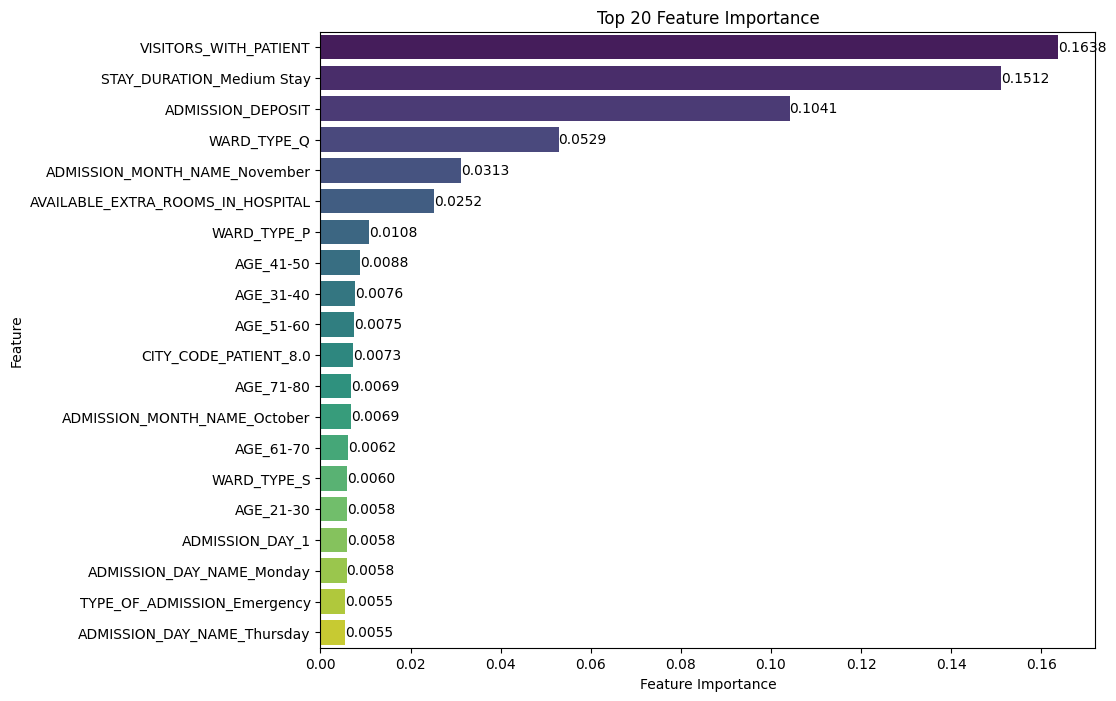

In [ ]:

# Create a figure and axes
plt.figure(figsize=(10, 8))

# Create a bar plot using seaborn
ax = sns.barplot(x='imp', y='feature', data=feat_imp[:20], orient='h', palette='viridis')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')

# Annotate the bars with feature importance values
for p in ax.patches:
    width = p.get_width()
    plt.text(width, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

# Show the plot
plt.show()

In [ ]:
# Selecting features with atleast 1% importance value
display(feat_imp[feat_imp['imp']>=0.008])
final_features_dtree = feat_imp[feat_imp['imp']>=0.008]['feature'].values.tolist()
print(len(final_features_dtree))
final_features_dtree[:5]

,feature,imp
1,VISITORS_WITH_PATIENT,0.163825
186,STAY_DURATION_Medium Stay,0.151168
2,ADMISSION_DEPOSIT,0.104140
30,WARD_TYPE_Q,0.052854
136,ADMISSION_MONTH_NAME_November,0.031258
0,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,0.025156
29,WARD_TYPE_P,0.010848
93,AGE_41-50,0.008795


8


['VISITORS_WITH_PATIENT',
 'STAY_DURATION_Medium Stay',
 'ADMISSION_DEPOSIT',
 'WARD_TYPE_Q',
 'ADMISSION_MONTH_NAME_November']

### **XGB Selection:** 

* Feature Importance: XGBoost provides a mechanism for calculating feature importance scores during the training process. These scores represent the contribution of each feature (variable) in making accurate predictions.

* XGB Feature Selection: XGB selection involves using the feature importance scores generated by XGBoost to identify and select the most influential features in a dataset. Features with higher importance scores are considered more critical in making predictions, while less important features may be excluded.

* Benefits: XGB feature selection can lead to more efficient and interpretable models by focusing on the most informative features. It helps reduce dimensionality, mitigate overfitting, and improve model generalization.

* Implementation: To perform XGB feature selection, you typically train an XGBoost model on your dataset, extract the feature importance scores, and then decide which features to keep based on a predefined threshold or other criteria.

In [ ]:
xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.5048725879725496

In [ ]:
# Feature Importance
feat_imp = (pd.DataFrame(zip(x_train.columns,xgb_.feature_importances_),columns=['feature','imp'])
            .sort_values(by='imp',ascending=False))
display(feat_imp[:20])


,feature,imp
185,STAY_DURATION_Long Stay,0.389352
30,WARD_TYPE_Q,0.107387
29,WARD_TYPE_P,0.059270
103,ADMISSION_MONTH_11,0.045643
1,VISITORS_WITH_PATIENT,0.025781
16,CITY_CODE_HOSPITAL_7,0.014932
102,ADMISSION_MONTH_10,0.014710
87,SEVERITY_OF_ILLNESS_Minor,0.013358
84,TYPE_OF_ADMISSION_Trauma,0.009531
32,WARD_TYPE_S,0.008910


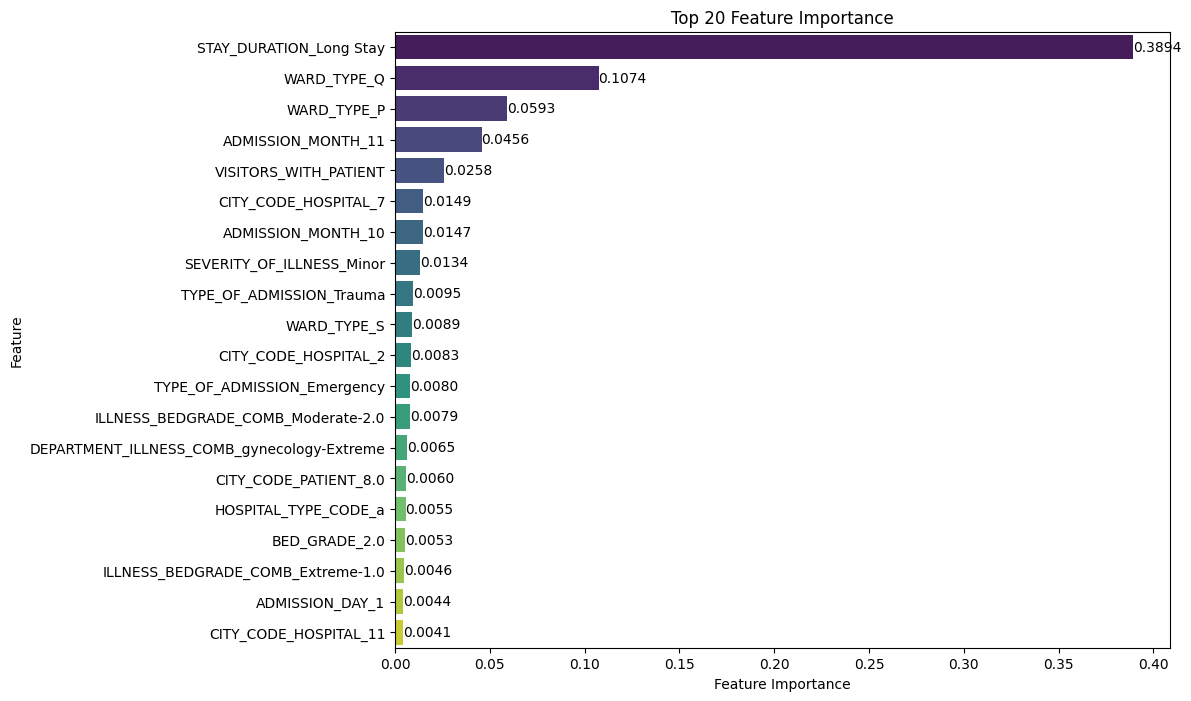

In [ ]:
# Create a figure and axes
plt.figure(figsize=(10, 8))

# Create a bar plot using seaborn
ax = sns.barplot(x='imp', y='feature', data=feat_imp[:20], orient='h', palette='viridis')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')

# Annotate the bars with feature importance values
for p in ax.patches:
    width = p.get_width()
    plt.text(width, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

# Show the plot
plt.show()

In [ ]:
# Selecting features with atleast .08% importance value
display(feat_imp[feat_imp['imp']>=0.008][:15])
final_features_xgb = feat_imp[feat_imp['imp']>=0.008]['feature'].values.tolist()
print(len(final_features_xgb))
final_features_xgb[:5]

,feature,imp
185,STAY_DURATION_Long Stay,0.389352
30,WARD_TYPE_Q,0.107387
29,WARD_TYPE_P,0.059270
103,ADMISSION_MONTH_11,0.045643
1,VISITORS_WITH_PATIENT,0.025781
16,CITY_CODE_HOSPITAL_7,0.014932
102,ADMISSION_MONTH_10,0.014710
87,SEVERITY_OF_ILLNESS_Minor,0.013358
84,TYPE_OF_ADMISSION_Trauma,0.009531
32,WARD_TYPE_S,0.008910


12


['STAY_DURATION_Long Stay',
 'WARD_TYPE_Q',
 'WARD_TYPE_P',
 'ADMISSION_MONTH_11',
 'VISITORS_WITH_PATIENT']

#### **Feature Union:** 

* Combining Features: A feature union combines these multiple feature sets into a single unified feature matrix. This can involve concatenating columns horizontally or using other techniques to merge the data.

* Improved Model Performance: By combining features from different sources, a feature union can enhance a machine learning model's ability to capture complex patterns and relationships within the data. It can lead to better model performance, especially when there is information redundancy or when some features are more informative in specific contexts.

* Implementation: Implementing a feature union typically involves using libraries like scikit-learn in Python, which provides tools like FeatureUnion to perform this operation seamlessly. You specify the different feature sets, and the library takes care of the concatenation.

In [ ]:
print("Total Features from Dtree: "+str(len(final_features_dtree)))
print("Total Features from XGB: "+str(len(final_features_xgb)))

Total Features from Dtree: 8
Total Features from XGB: 12


In [ ]:
model_features =  list(set(final_features_dtree).union(set(final_features_xgb)))
print("Final Features from both Dtree & XGB: "+str(len(model_features)))

Final Features from both Dtree & XGB: 17


In [ ]:
model_features

['TYPE_OF_ADMISSION_Emergency',
 'AGE_41-50',
 'CITY_CODE_HOSPITAL_7',
 'VISITORS_WITH_PATIENT',
 'WARD_TYPE_S',
 'ADMISSION_MONTH_NAME_November',
 'TYPE_OF_ADMISSION_Trauma',
 'ADMISSION_MONTH_11',
 'CITY_CODE_HOSPITAL_2',
 'WARD_TYPE_P',
 'STAY_DURATION_Long Stay',
 'ADMISSION_DEPOSIT',
 'ADMISSION_MONTH_10',
 'SEVERITY_OF_ILLNESS_Minor',
 'WARD_TYPE_Q',
 'STAY_DURATION_Medium Stay',
 'AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL']

In [ ]:
df_final[model_features+['LENGTH_OF_STAY']].to_pickle('MODEL_training_data_with_final_features.pkl')

In [ ]:
# import pickle
#This will save the features we want to focus on including length of stay 
final_feats_list = model_features+['LENGTH_OF_STAY']

with open('MODEL_FEATS.pkl','wb') as F:
     pickle.dump(final_feats_list,F)

## **Model Building**

In this section, we will explore the implementation of three regression models to predict our target variable. We will consider the following models:

* ### 1. Linear Regression:
    * Linear regression is a simple and interpretable regression model that assumes a linear relationship between the features and the target variable.

* ### 2. Random Forest Regression
    * Random Forest Regression is an ensemble learning technique that combines multiple decision trees to make predictions. It is robust and can capture complex relationships.

* ### 3. XGB Regression
    * XGBoost Regression is another ensemble learning method known for its high performance. It uses gradient boosting and is effective for a wide range of regression tasks.


In [ ]:
df_features = pd.read_pickle('MODEL_training_data_with_final_features.pkl')
print(df_features.shape)
df_features.head(3)

(236704, 18)


,TYPE_OF_ADMISSION_Emergency,AGE_41-50,CITY_CODE_HOSPITAL_7,VISITORS_WITH_PATIENT,WARD_TYPE_S,ADMISSION_MONTH_NAME_November,TYPE_OF_ADMISSION_Trauma,ADMISSION_MONTH_11,CITY_CODE_HOSPITAL_2,WARD_TYPE_P,STAY_DURATION_Long Stay,ADMISSION_DEPOSIT,ADMISSION_MONTH_10,SEVERITY_OF_ILLNESS_Minor,WARD_TYPE_Q,STAY_DURATION_Medium Stay,AVAILABLE_EXTRA_ROOMS_IN_HOSPITAL,LENGTH_OF_STAY
CASE_ID,,,,,,,,,,,,,,,,,,
1,1,0,0,2,0,0,0,0,0,0,0,4911,0,0,0,1,3,10
3,0,0,0,2,1,0,1,0,0,0,1,4745,0,0,0,0,2,40
4,0,0,0,2,0,0,1,0,1,0,1,7272,0,0,0,0,2,50


In [ ]:
# Train and Test split
X = df_features.drop('LENGTH_OF_STAY',axis=1)
y = df_features[['LENGTH_OF_STAY']]
print(X.shape,y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(236704, 17) (236704, 1)
(165692, 17) (165692, 1)
(71012, 17) (71012, 1)


### 1. Linear Regression:

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_train,y_train)

0.2888982086301016

In [ ]:
preds = np.ceil(lr.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  14.19364988128944
MAE:  3.2277951661549555


### 2. Random Forest Regression:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train,y_train)
rf.score(x_train,y_train)

0.8913601261724008

In [ ]:
preds = np.ceil(rf.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  13.968557525217971
MAE:  3.139726608269373


In [ ]:
preds

array([40., 30., 24., ..., 44., 37., 24.])

### 3. XGB Regression:

In [ ]:
import xgboost as xgb

xgb_ = xgb.XGBRegressor()
xgb_.fit(x_train,y_train)
xgb_.score(x_train,y_train)

0.4622802360899323

In [ ]:
preds = np.ceil(xgb_.predict(x_test))
rmse = np.sqrt(metrics.mean_squared_error(y_test,preds))
mae = np.sqrt(metrics.mean_absolute_error(y_test,preds))
print("RMSE: ", rmse)
print("MAE: ", mae)

RMSE:  12.734406105371828
MAE:  3.0020599773280336


In [ ]:
 # Saving the trained model
 booster = xgb_.get_booster()
 booster.save_model('MODEL_XGB.model')

## **Additional Regressions:**

### 4. Ridge Regression: 
* Linear regression with L2 regularization.
* Controls overfitting by penalizing large coefficients.
* L2 regularization term with hyperparameter alpha.
* Shrinks less important features' coefficients.
* Balances bias and variance.


In [ ]:
from sklearn.linear_model import Ridge
# Ridge Regression
ridge = Ridge(alpha=1.0)  # You can adjust the alpha (regularization strength) as needed
ridge.fit(x_train, y_train)
ridge_preds = np.ceil(ridge.predict(x_test))

In [ ]:
ridge_rmse = np.sqrt(metrics.mean_squared_error(y_test, ridge_preds))
ridge_mae = np.sqrt(metrics.mean_absolute_error(y_test, ridge_preds))
ridge_train_r2 = ridge.score(x_train, y_train)  # Calculate training R-squared
ridge_test_r2 = r2_score(y_test, ridge_preds)  # Calculate test R-squared
print("Ridge Regression RMSE:", ridge_rmse)
print("Ridge Regression MAE:", ridge_mae)
print("Ridge Regression Training R-squared:", ridge_train_r2)
print("Ridge Regression Test R-squared:", ridge_test_r2)

Ridge Regression RMSE: 14.193606723013774
Ridge Regression MAE: 3.227784259212266
Ridge Regression Training R-squared: 0.28889820808264577
Ridge Regression Test R-squared: 0.2867058192589992


### 5. Lasso Regression:

* Linear regression with L1 regularization.
* Controls overfitting by encouraging sparse coefficients.
* L1 regularization term with hyperparameter alpha.
* Performs feature selection by setting some coefficients to zero.
* Balances bias and variance.
* Effective for feature selection and multicollinearity.

In [ ]:

lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)
lasso_preds = np.ceil(lasso.predict(x_test))

In [ ]:
lasso_rmse = np.sqrt(metrics.mean_squared_error(y_test, lasso_preds))
lasso_mae = np.sqrt(metrics.mean_absolute_error(y_test, lasso_preds))
lasso_train_r2 = lasso.score(x_train, y_train)
lasso_test_r2 = r2_score(y_test, lasso_preds)
print("Lasso Regression RMSE:", lasso_rmse)
print("Lasso Regression MAE:", lasso_mae)
print("Lasso Regression Training R-squared:", lasso_train_r2)
print("Lasso Regression Test R-squared:", lasso_test_r2)

Lasso Regression RMSE: 15.184525185311617
Lasso Regression MAE: 3.3622162082995866
Lasso Regression Training R-squared: 0.1840012358196671
Lasso Regression Test R-squared: 0.18363274197821122


### 6. Huber Regression:
* Combines characteristics of least squares and absolute error loss.
* Uses the Huber loss function to reduce sensitivity to outliers.
* Controlled by the epsilon parameter to adjust the robustness.

In [ ]:
huber = HuberRegressor(epsilon=1.35)
huber.fit(x_train, y_train)
huber_preds = np.ceil(huber.predict(x_test))

In [ ]:
huber_rmse = np.sqrt(metrics.mean_squared_error(y_test, huber_preds))
huber_mae = np.sqrt(metrics.mean_absolute_error(y_test, huber_preds))
huber_train_r2 = huber.score(x_train, y_train)
huber_test_r2 = r2_score(y_test, huber_preds)
print("Huber Regression RMSE:", huber_rmse)
print("Huber Regression MAE:", huber_mae)
print("Huber Regression Training R-squared:", huber_train_r2)
print("Huber Regression Test R-squared:", huber_test_r2)

Huber Regression RMSE: 14.585152724525955
Huber Regression MAE: 3.180268459547557
Huber Regression Training R-squared: 0.24441243332124918
Huber Regression Test R-squared: 0.24680902436471608


## **Picking the Best Model**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
import numpy as np

# Define a list of regression models to evaluate
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest Regressor", RandomForestRegressor()),
    ("XGBoost Regressor", xgb.XGBRegressor()),
]

# Loop through each model and evaluate its performance
for model_name, model in models:
    # Fit the model to the training data
    model.fit(x_train, y_train)
    
    # Calculate the R-squared score on the training data
    train_r2 = model.score(x_train, y_train)
    
    # Make predictions on the test data
    preds = np.ceil(model.predict(x_test))
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
    mae = np.sqrt(metrics.mean_absolute_error(y_test, preds))
    

    # Check if this model has the lowest RMSE so far
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = model_name

    # Print model evaluation results
    print(f"Model: {model_name}")
    print(f"Train R-squared: {train_r2:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print()
    
print(f"The best model is: {best_model_name} with RMSE: {best_rmse:.2f}")


Model: Linear Regression
Train R-squared: 0.29
RMSE: 14.19
MAE: 3.23

Model: Random Forest Regressor
Train R-squared: 0.89
RMSE: 13.96
MAE: 3.14

Model: XGBoost Regressor
Train R-squared: 0.46
RMSE: 12.73
MAE: 3.00

The best model is: XGBoost Regressor with RMSE: 12.73


In [ ]:
##Creating a function to pick best model

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
import numpy as np
import joblib  # Import joblib to save the best model

def train_and_save_best_model(x_train, y_train, x_test, y_test, save_path):
    # Define a list of regression models to evaluate
    models = [
        ("Linear Regression", LinearRegression()),
        ("Random Forest Regressor", RandomForestRegressor()),
        ("XGBoost Regressor", xgb.XGBRegressor()),
    ]

    best_model_name = ""
    best_rmse = float("inf")

    # Loop through each model and evaluate its performance
    for model_name, model in models:
        # Fit the model to the training data
        model.fit(x_train, y_train)
        
        # Calculate the R-squared score on the training data
        train_r2 = model.score(x_train, y_train)
        
        # Make predictions on the test data
        preds = np.ceil(model.predict(x_test))
        
        # Calculate RMSE and MAE
        rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
        mae = np.sqrt(metrics.mean_absolute_error(y_test, preds))
        
        # Check if this model has the lowest RMSE so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = model_name

        # Print model evaluation results
        print(f"Model: {model_name}")
        print(f"Train R-squared: {train_r2:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print()
    
    # Save the best model to a file using joblib
    best_model = [model for model_name, model in models if model_name == best_model_name][0]
    joblib.dump(best_model, save_path)
    
    print(f"The best model is: {best_model_name} with RMSE: {best_rmse:.2f}")
    print(f"The best model has been saved to {save_path}")

